In [1]:
from utils import file_utils as fu
from smooth import method_factory as mf_smoothing
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

area = 'tw_oc'
m = 'smoothing'
dim = -1# not used here
smooth_method = mf_smoothing[m]()

train, val, test = fu.load_data(area)
I,L = train.shape

%matplotlib inline

2016-08-02 12:38:17,905 INFO --> Mem and popularity learnt from training data; searching alpha on validation set
2016-08-02 12:38:17,907 INFO --> Loading all data for area tw_oc


In [2]:
%%time
binary = (train>0)*1#I*L
count_1d = binary.sum(axis = 0)#1*L
count_2d = np.dot(binary.T,binary)#L*L
P_1d = count_1d/I # exists zeros
P_2d = count_2d/I
temp = P_2d/np.outer(P_1d,P_1d)
temp[ ~ np.isfinite( temp )]= 1 # zero / zero = zero
temp[temp==0]=1 # avoid log_zero
PPMI = np.log2(temp)
PPMI[PPMI<0] = 0

CPU times: user 2.81 s, sys: 1.52 s, total: 4.33 s
Wall time: 4.34 s


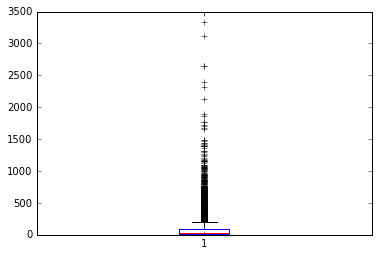

In [3]:
NON_ZEROS = [np.count_nonzero(PPMI[i]) for i in range(L)]
plt.boxplot(NON_ZEROS)
plt.show()

In [4]:
k = 50
idx = np.array([[j for j in np.asarray(PPMI[i].argsort().T).reshape(-1)[-k:][::-1] 
                 if PPMI[i,j]>0] for i in range(L)])
for u in range(L):
    if u not in idx[u]:
        idx[u].append(u)

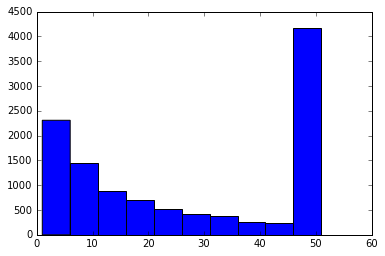

In [5]:
plt.hist([len(i) for i in idx])
plt.show()

In [6]:
%%time
# compute mutual information for these indices
# need to use dense matrix here
binary = (np.array(train.toarray())>0)*1#I*L
MI = np.zeros((L,L))
from sklearn import metrics
for u in range(L):
    for w in idx[u]:
        MI[u,w] = metrics.mutual_info_score(None, None, 
                contingency=np.histogram2d(binary[:,u], binary[:,w])[0])

CPU times: user 10min 56s, sys: 10.4 s, total: 11min 6s
Wall time: 11min 44s


In [7]:
from utils.helpers import normalize_mat_row, col_vector
MI = normalize_mat_row(MI)
MI[ ~ np.isfinite( MI )]= 0 # ALL ZEROS IN A ROW

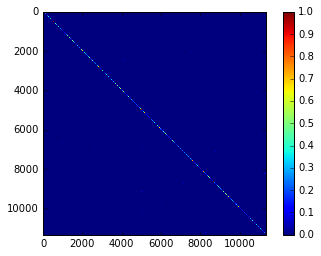

In [8]:
plt.imshow(MI, interpolation='nearest')
plt.colorbar()
plt.show()
# very sparse

In [5]:
import numpy as np
alpha,mu = 0.5,0.5
I,L = 2,2
MI = np.array([[0.9,0.1],[0.8,0.2]])
mem_mult = np.array([[0.5,0.5],[1,0]])
pref = np.zeros((I,L))
trans = MI*(1-alpha)+np.identity(L)*alpha
for i in range(I):
    pref[i] = np.sum(trans *(mem_mult[i][:, np.newaxis]), axis=0)
stm_scores = pref 
print(stm_scores)

[[ 0.675  0.325]
 [ 0.95   0.05 ]]


In [9]:
import numpy as np
alpha,mu = 0.5,0.5
I,L = 2,2
MI = np.array([[0.9,0.1],[0.8,0.2]])
mem_mult = np.array([[0.5,0.5],[1,0]])
pref = np.zeros((I,L))
trans = MI*(1-alpha)+np.identity(L)*alpha
pref =  np.dot(mem_mult,trans)
stm_scores = pref 
print(stm_scores)

[[ 0.675  0.325]
 [ 0.95   0.05 ]]
